# Notebook for ZFOURGE CDFS Bolometric Luminosity Functions

### Import and setup

In [42]:
import pandas as pd

data = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN2.csv')
CDFS = pd.DataFrame(data)
CDFS['source'] = 'CDFS'

data = pd.read_csv('../DATA/ZFOURGE/COSMOS/COSMOS_MAIN2.csv')
COSMOS = pd.DataFrame(data)
COSMOS['source'] = 'COSMOS'

data = pd.read_csv('../DATA/ZFOURGE/UDS/UDS_MAIN2.csv')
UDS = pd.DataFrame(data)
UDS['source'] = 'UDS'

df = pd.concat([CDFS, COSMOS, UDS], ignore_index=True)

use_mask = df['Use'] == 1
LIR_mask = df['LIR'] > 0
AGN_mask = (df['irAGN'] == 1) | (df['radAGN'] == 1) | (df['xAGN'] == 1)

print(f'Total Galaxies: {len(df)}')
df = df[use_mask]
print(f'Galaxies use=1: {len(df)}')
df = df.loc[LIR_mask]
print(f'Galaxies LIR > 0: {len(df)}')
df = df.loc[~AGN_mask]
print(f'# Galaxies: {len(df)}')
print(f'# AGN Galaxies {sum(AGN_mask)}')

print(max(df['zpk']))

Total Galaxies: 73790
Galaxies use=1: 37647
Galaxies LIR > 0: 22997
# Galaxies: 22472
# AGN Galaxies 552
7.9691


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM, z_at_value
import astropy.units as u

redshift_bins = [(0.00, 0.30), (0.30, 0.45), (0.45, 0.60), 
                 (0.60, 0.80), (0.80, 1.00), (1.00, 1.20),
                 (1.20, 1.70), (1.70, 2.00), (2.00, 2.50),
                 (2.50, 3.00), (3.00, 4.20), (4.20, 6.00)] # redshift bins
survey_area = 0.03556 # CDFS survey area in square degrees
survey_area = 0.1111 # Total ZFOURGE survey area in square degrees
min_count = 5 # minimum number of galaxies in a bin
lum_bin_edges = np.arange(8, 14, 0.25) # luminosity bin edges
# lum_bin_edges = np.arange(8, 14, 0.5) # luminosity bin edges
# lum_bin_edges = np.arange(8.25, 14.25, 0.5) # luminosity bin edges
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
percentiles = [25, 25, 25, 
               20, 20, 20, 
               25, 20, 20, 
               25, 50, 35] # percentiles for each redshift bin all ZFOURGE

df = df[(df['zpk'] >= redshift_bins[0][0]) & (df['zpk'] <= redshift_bins[-1][1])]
print(f'# Galaxies: {len(df)}')

# Galaxies: 22444


### Quiescent vs Starforming

In [ ]:
U = df['FU'] # uJy
V = df['FV'] # uJy
J = df['FJ'] # uJy

U_ab = 25 - 2.5*np.log10(U) # apparent magnitude -> AB magnitude
V_ab = 25 - 2.5*np.log10(V) # apparent magnitude -> AB magnitude
J_ab = 25 - 2.5*np.log10(J) # apparent magnitude -> AB magnitude

U_V = U_ab - V_ab
V_J = V_ab - J_ab

mask_q = (U_V > 1.3) & (V_J < 1.6) & (U_V > 0.88*V_J+0.59)
print(f'Quiescent: {mask_q.sum()}')
print(f'Star-forming: {len(U_V) - mask_q.sum()}')

df = df[mask_q] # 1,502 - quiescent
# df = df[~mask_q] # 20,942 - star-forming

plt.scatter(V_J[mask_q], U_V[mask_q], s=1, label='Quiescent', color='red')
plt.scatter(V_J[~mask_q], U_V[~mask_q], s=1, label='Star-forming', color='blue')
plt.xlabel('$V - J$')
plt.ylabel('$U - V$')
plt.xlim(0, 2.5)
plt.ylim(0, 2.5)
plt.hlines(1.3, 0, 0.8, colors='red', linestyles='dashed')
plt.vlines(1.6, 2, 2.5, colors='red', linestyles='dashed')
plt.plot([0.8, 1.6], [1.3, 2.0], color='red', linestyle='dashed')
plt.legend()
plt.show()

### Luminosity vs Redshift

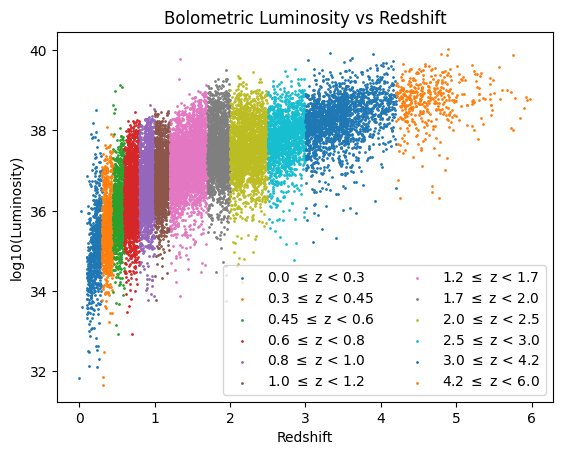

In [44]:
luminosity = df['LIR'].copy().values # solar luminosities
luminosity *= 3.828 * 10 ** 26 # solar luminosity -> Watts
z = df['zpk'].values # redshift

for z_start, z_end in redshift_bins:
    mask = (z >= z_start) & (z < z_end)
    plt.scatter(z[mask], np.log10(luminosity[mask]), s=1, label=f'{z_start} $\leq$ z < {z_end}')
plt.title('Bolometric Luminosity vs Redshift')
plt.ylabel('log10(Luminosity)')
plt.xlabel('Redshift')
plt.legend(ncols=2)
plt.show()

### Luminosity-distance relationship

1) Calculate the maximum distance using given luminosity, $L_{IR}$, and the flux limit of survey, $F_{lim}$. This effectively calculates the maximum possible distance of the galaxy given we know it's instrinsic luminosity but if it's flux were at the survey limit.

$$
D_{max} = \sqrt{\frac{L}{4 \pi F_{lim}}}
$$


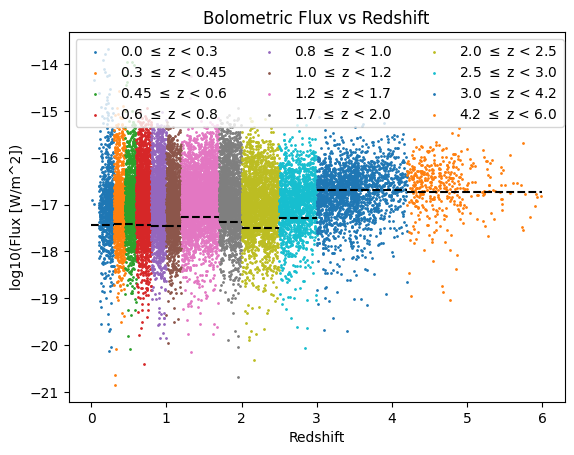

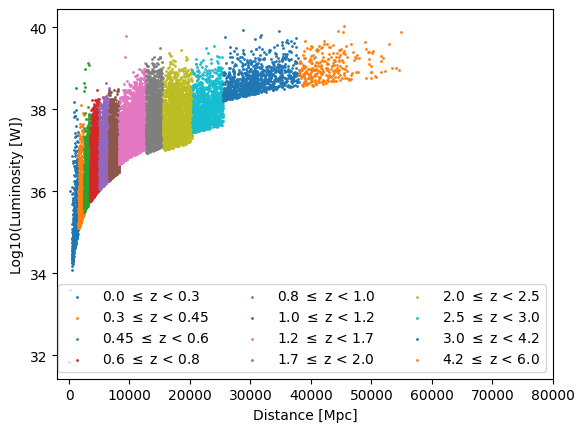

In [45]:
# Luminsity distance of galaxies
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
d_L = cosmo.luminosity_distance(z).to('m').value # m

F_bol = luminosity / (4 * np.pi * d_L ** 2) # W/m^2

F_lims = []
for (z_start, z_end), perc in zip(redshift_bins, percentiles):
    mask_z = (z >= z_start) & (z < z_end)
    try:
        p = np.percentile(F_bol[mask_z], perc) # % of the data above perc
    except IndexError:
        p = 0
    F_lims.append(p)
    mask_f = F_bol <= p
    luminosity[mask_f & mask_z] = 0 # remove galaxies with flux below p
    plt.scatter(z[mask_z], np.log10(F_bol[mask_z]), s=1, label=f'{z_start} $\leq$ z < {z_end}')
    plt.hlines(np.log10(p), z_start, z_end, color='black', linestyle='--')
plt.title('Bolometric Flux vs Redshift')
plt.ylabel('log10(Flux [W/m^2])')
plt.xlabel('Redshift')
plt.legend(loc='upper left', ncols=3)
plt.show()

# Remove galaxies with no luminosity
mask_l = luminosity > 0
luminosity = luminosity[mask_l]
z = z[mask_l]
d_L = d_L[mask_l]
    
# Maximum distance of galaxies (eq 2)
dmaxs = np.zeros(len(luminosity))
for (z_start, z_end), F_lim in zip(redshift_bins, F_lims):
    mask_z = (z >= z_start) & (z < z_end)
    dmaxs[mask_z] = np.sqrt(luminosity[mask_z] / (4 * np.pi * F_lim))

z_lim = z_at_value(cosmo.luminosity_distance, dmaxs * u.m)

for z_start, z_end in redshift_bins:
    mask_z = (z >= z_start) & (z < z_end)
    plt.scatter(d_L[mask_z]*3.241*10**-23, np.log10(luminosity[mask_z]), s=1, label=f'{z_start} $\leq$ z < {z_end}')
    # plt.scatter(dmaxs[mask_z]*3.241*10**-23, np.log10(luminosity[mask_z]), s=1, c=c)
plt.xlabel('Distance [Mpc]')
plt.ylabel('Log10(Luminosity [W])')
plt.xlim(-2000, 80000)
plt.legend(loc='lower right', ncols=3)
plt.show()

### Luminosity Bin Limits vs Maximum Redshift

This shows that when calculating the maximum possible distance, to eventually calculate volume, the luminosities no longer follow the `luminosity_distance` limit and instead follow the `comoving_distance` limit. This must be corrected by excluding sources below the `luminosity_distance` limit.

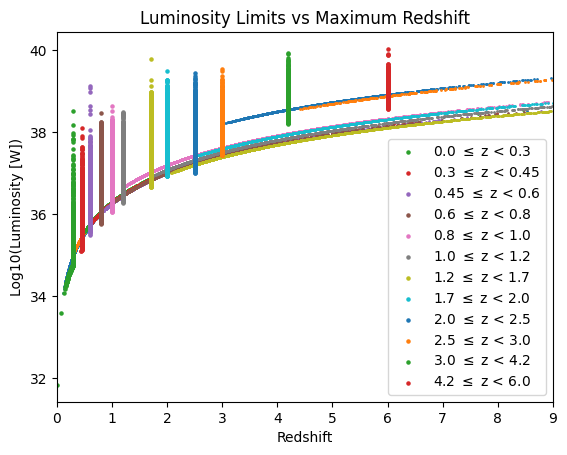

In [46]:
for z_min, z_max in redshift_bins:
    mask_z = (z >= z_min) & (z < z_max)
    plt.scatter(z_lim[mask_z], np.log10(luminosity[mask_z]), s=1)
    
for (z_min, z_max), F_lim in zip(redshift_bins, F_lims):
    mask = (z >= z_min) & (z < z_max)
    
    lum_bin = np.log10(luminosity)[mask]
    
    # Find the maximum distance for the redshift bin
    dmin = cosmo.comoving_distance(z_min).value # Mpc
    dmax = cosmo.comoving_distance(z_max).value # Mpc
    
    # Find the maximum distance for each source
    dmaxs = np.sqrt(luminosity[mask] / (4*np.pi*F_lim)) # meters
    dmaxs *= 3.241 * 10 ** -23 # meters -> Mpc
    
    # Only use luminosity bins that are possible in the redshift range
    d_mask = dmaxs >= dmin
    dmaxs = dmaxs[d_mask]
    lum_bin = lum_bin[d_mask]
        
    # Limit the distance to the maximum distance
    dmaxs[dmaxs > dmax] = dmax
    
    # Find the redshift at the maximum distance
    try:
        z_lims = z_at_value(cosmo.comoving_distance, dmaxs * u.Mpc)
    except ValueError:
        continue
    plt.scatter(z_lims, lum_bin, s=5, label=f'{z_min} $\leq$ z < {z_max}')
    
plt.title('Luminosity Limits vs Maximum Redshift')
plt.xlabel('Redshift')
plt.ylabel('Log10(Luminosity [W])')
plt.legend(loc='lower right')
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1]+3)
plt.show()

### Calculate Maximum Volume

Correcting for the above

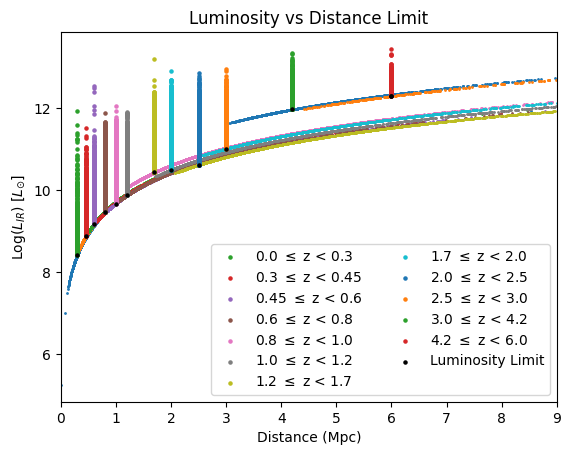

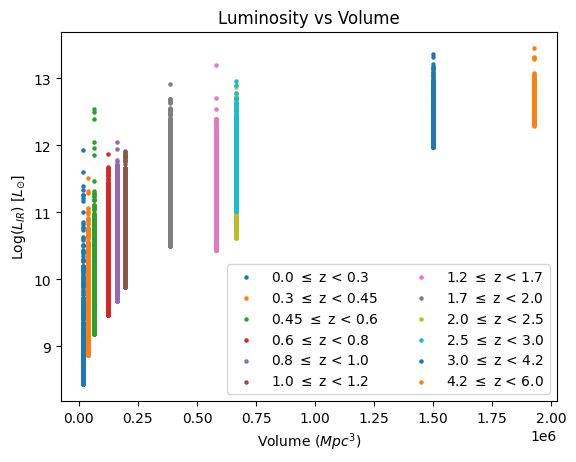

In [47]:
def lum_lim(z_in):
    return (luminosity/(3.83*10**26))[mask][np.argmin(np.abs(z_lim[mask] - z_in))]

all_data = []
min_ls = []

for z_min, z_max in redshift_bins:
    mask_z = (z >= z_min) & (z < z_max)
    plt.scatter(z_lim[mask_z], np.log10(luminosity[mask_z]/(3.83*10**26)), s=1)
    
for (z_min, z_max), F_lim in zip(redshift_bins, F_lims):
    mask = (z >= z_min) & (z < z_max)
    
    lum_bin = np.log10(luminosity[mask]/(3.83*10**26))
    
    # Calculate the minimum and maximum distance of the redshift bin
    dmin = cosmo.comoving_distance(z_min).value # Mpc
    dmax = cosmo.comoving_distance(z_max).value # Mpc
    
    # Find the maximum distance for each source
    dmaxs = np.sqrt(luminosity[mask] / (4*np.pi*F_lim)) # meters
    dmaxs *= 3.241 * 10 ** -23 # meters -> Mpc
    
    # Distances must be greater than the minimum distance
    d_mask = dmaxs >= dmin
    
    # Lumiosity bins must be greater than or equal to the minimum luminosity (from luminosity distance)
    try:
        l = lum_lim(z_max)
    except ValueError:
        all_data.append([vol, lum_bin])
        min_ls.append(0)
    mlim_mask = lum_bin >= np.log10(l)
    min_ls.append(l)
    
    # Apply masks
    dmaxs = dmaxs[d_mask & mlim_mask]
    lum_bin = lum_bin[d_mask & mlim_mask]
    
    # If the maximum distance is greater than the maximum redshift bin distance, set it to the maximum redshift bin distance
    dmaxs[dmaxs > dmax] = dmax
    
    # Calculate the minimum volume of the redshift bin
    vmin = 4/3 * np.pi * dmin**3 # Mpc^3

    # Calculate the maximum volume of each luminosity bin
    vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3
    
    # Total volume probed accounting for survey area
    vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
    
    all_data.append([vol, lum_bin])
    
    try:
        z_lims = z_at_value(cosmo.comoving_distance, dmaxs * u.Mpc)
    except ValueError:
        continue
    plt.scatter(z_lims, lum_bin, s=5, label=f'{z_min} $\leq$ z < {z_max}')
    plt.scatter(z_max, np.log10(l), s=5, color='black')

plt.scatter(z_max, np.log10(l), s=5, color='black', label='Luminosity Limit')
plt.title('Luminosity vs Distance Limit')
plt.xlabel('Distance (Mpc)')
plt.ylabel('Log($L_{IR}$) [$L_{\odot}$]')
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1]+3)
plt.legend(loc='lower right', ncols=2)
plt.show()

plt.title('Luminosity vs Volume')
for (v, m), (z_start, z_end) in zip(all_data, redshift_bins):
    try:
        plt.scatter(v, m, s=5, label=f'{z_start} $\leq$ z < {z_end}')
    except ValueError:
        continue
plt.xlabel('Volume $(Mpc^3)$')
plt.ylabel('Log($L_{IR}$) [$L_{\odot}$]')
plt.legend(loc='lower right', ncols=2)
plt.show()

### Counts Histograms

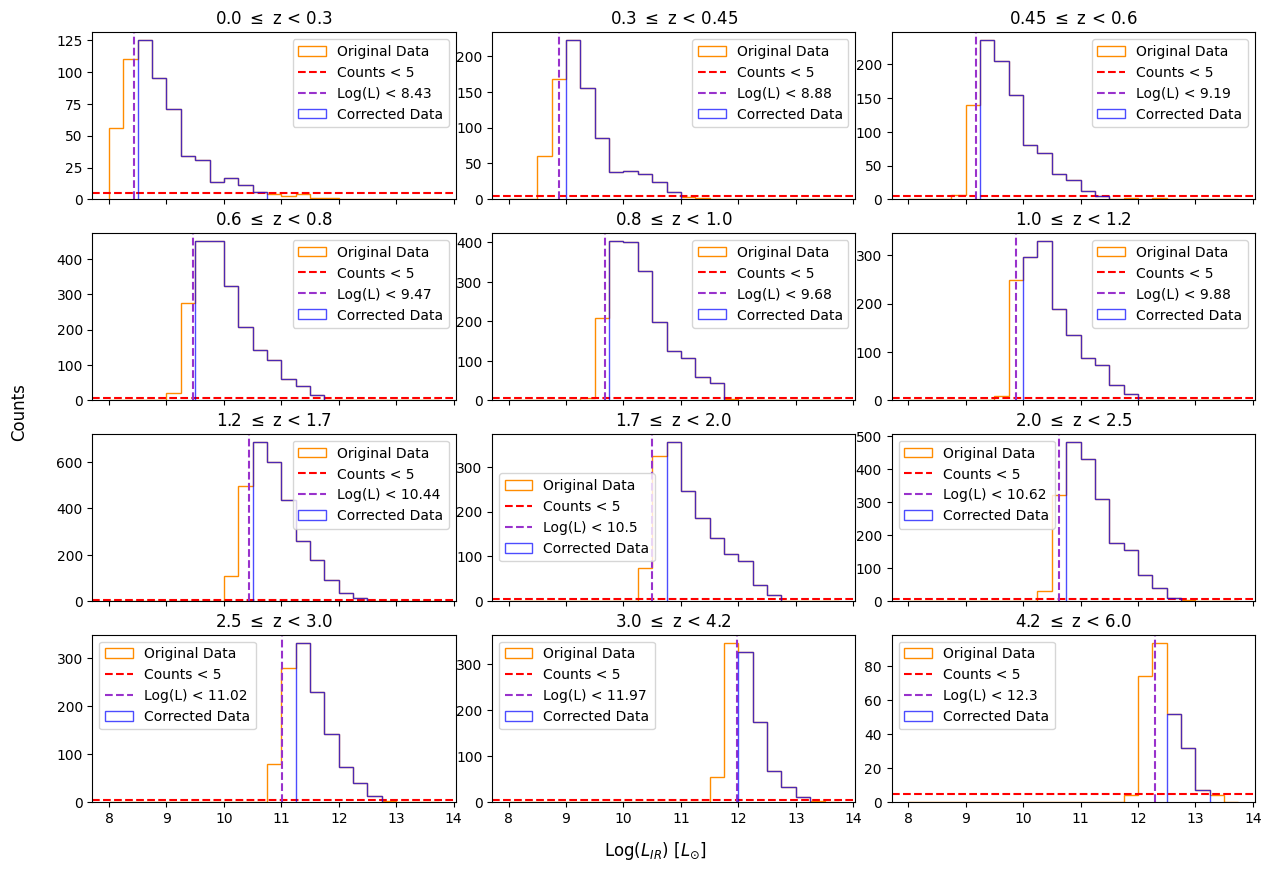

0.0 <= z < 0.3
Flux Completeness: 3.59e-18
Luminosity Completeness: 8.43


0.3 <= z < 0.45
Flux Completeness: 3.84e-18
Luminosity Completeness: 8.88


0.45 <= z < 0.6
Flux Completeness: 3.93e-18
Luminosity Completeness: 9.19


0.6 <= z < 0.8
Flux Completeness: 3.72e-18
Luminosity Completeness: 9.47


0.8 <= z < 1.0
Flux Completeness: 3.51e-18
Luminosity Completeness: 9.68


1.0 <= z < 1.2
Flux Completeness: 3.55e-18
Luminosity Completeness: 9.88


1.2 <= z < 1.7
Flux Completeness: 5.47e-18
Luminosity Completeness: 10.44


1.7 <= z < 2.0
Flux Completeness: 4.21e-18
Luminosity Completeness: 10.5


2.0 <= z < 2.5
Flux Completeness: 3.22e-18
Luminosity Completeness: 10.62


2.5 <= z < 3.0
Flux Completeness: 5.17e-18
Luminosity Completeness: 11.02


3.0 <= z < 4.2
Flux Completeness: 2.08e-17
Luminosity Completeness: 11.97


4.2 <= z < 6.0
Flux Completeness: 1.90e-17
Luminosity Completeness: 12.3




In [48]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True)
bin_edges = []
for (z_start, z_end), (vol, lum), ax, min_l in zip(redshift_bins, all_data, axes.flatten(), min_ls):
    
    # Bin the original data per redshift bin
    _, b, _ = ax.hist(np.log10(luminosity/(3.83*10**26))[(z >= z_start) & (z < z_end)], bins=lum_bin_edges, histtype='step', label='Original Data', color='darkorange')
    
    # Bin the new data with the same bins
    c, b = np.histogram(lum, bins=b)
    centers = (b[:-1] + b[1:]) / 2 # bin centers
    
    # Mask the bins with less than the minimum count
    c_mask = c >= min_count
    for _ in range(2): # should only need to run twice
        nci = np.where(np.diff(np.where(c_mask)[0]) != 1)[0] # non-consecutive indices: mask non-consecutive True values
        c_mask[np.where(c_mask)[0][nci + 1]] = False
    
    b = b[1:][c_mask] # this [1:] removes the first bin edge which is impacted by the mask (would be a fraction of the bin width)
    centers = centers[c_mask]
    c = c[c_mask]
    
    # Plot the mask cutoff
    ax.axhline(min_count, color='red', linestyle='--', label=f'Counts < {min_count}')
    ax.axvline(np.log10(min_l), color='darkorchid', linestyle='--', label=f'Log(L) < {round(np.log10(min_l), 2)}')
    ax.set_title(f'{z_start} $\leq$ z < {z_end}')
    
    # Skip if there are no bins
    if len(c) == 0:
        ax.legend()
        bin_edges.append([])
        continue
    
    # Plot the new, corrected data
    ax.hist(centers, b, weights=c, histtype='step', label='Corrected Data', color='blue', alpha=0.7)
    ax.legend()
    bin_edges.append(b)

fig.supylabel('Counts', x=0.07)
fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.show()

for min_l, (z_start, z_end), f_lim in zip(min_ls, redshift_bins, F_lims):
    print(f'{z_start} <= z < {z_end}')
    print(f'Flux Completeness: {f_lim:.2e}')
    print(f'Luminosity Completeness: {np.round(np.log10(min_l), 2)}')
    print('\n')

### Luminosity Function

0.0 <= z < 0.3
[8.625, 8.875, 9.125, 9.375, 9.625, 9.875, 10.125, 10.375, 10.625]
[-1.58 -1.7  -1.83 -2.15 -2.19 -2.54 -2.45 -2.64 -2.9 ]
[0.04 0.05 0.05 0.08 0.09 0.14 0.12 0.16 0.23]


0.3 <= z < 0.45
[9.125, 9.375, 9.625, 9.875, 10.125, 10.375, 10.625, 10.875]
[-1.64 -1.79 -2.05 -2.4  -2.38 -2.44 -2.6  -2.98]
[0.03 0.04 0.05 0.08 0.07 0.08 0.1  0.17]


0.45 <= z < 0.6
[9.375, 9.625, 9.875, 10.125, 10.375, 10.625, 10.875, 11.125, 11.375]
[-1.83 -1.89 -2.01 -2.3  -2.37 -2.62 -2.74 -3.09 -3.5 ]
[0.03 0.03 0.04 0.05 0.06 0.08 0.09 0.14 0.26]


0.6 <= z < 0.8
[9.625, 9.875, 10.125, 10.375, 10.625, 10.875, 11.125, 11.375, 11.625]
[-1.83 -1.83 -1.98 -2.17 -2.34 -2.43 -2.71 -2.89 -3.34]
[0.02 0.02 0.02 0.03 0.04 0.04 0.06 0.07 0.14]


0.8 <= z < 1.0
[9.875, 10.125, 10.375, 10.625, 10.875, 11.125, 11.375, 11.625]
[-2.   -2.   -2.09 -2.31 -2.52 -2.58 -2.85 -2.98]
[0.02 0.02 0.02 0.03 0.04 0.04 0.06 0.07]


1.0 <= z < 1.2
[10.125, 10.375, 10.625, 10.875, 11.125, 11.375, 11.625, 11.875]
[-2.21 

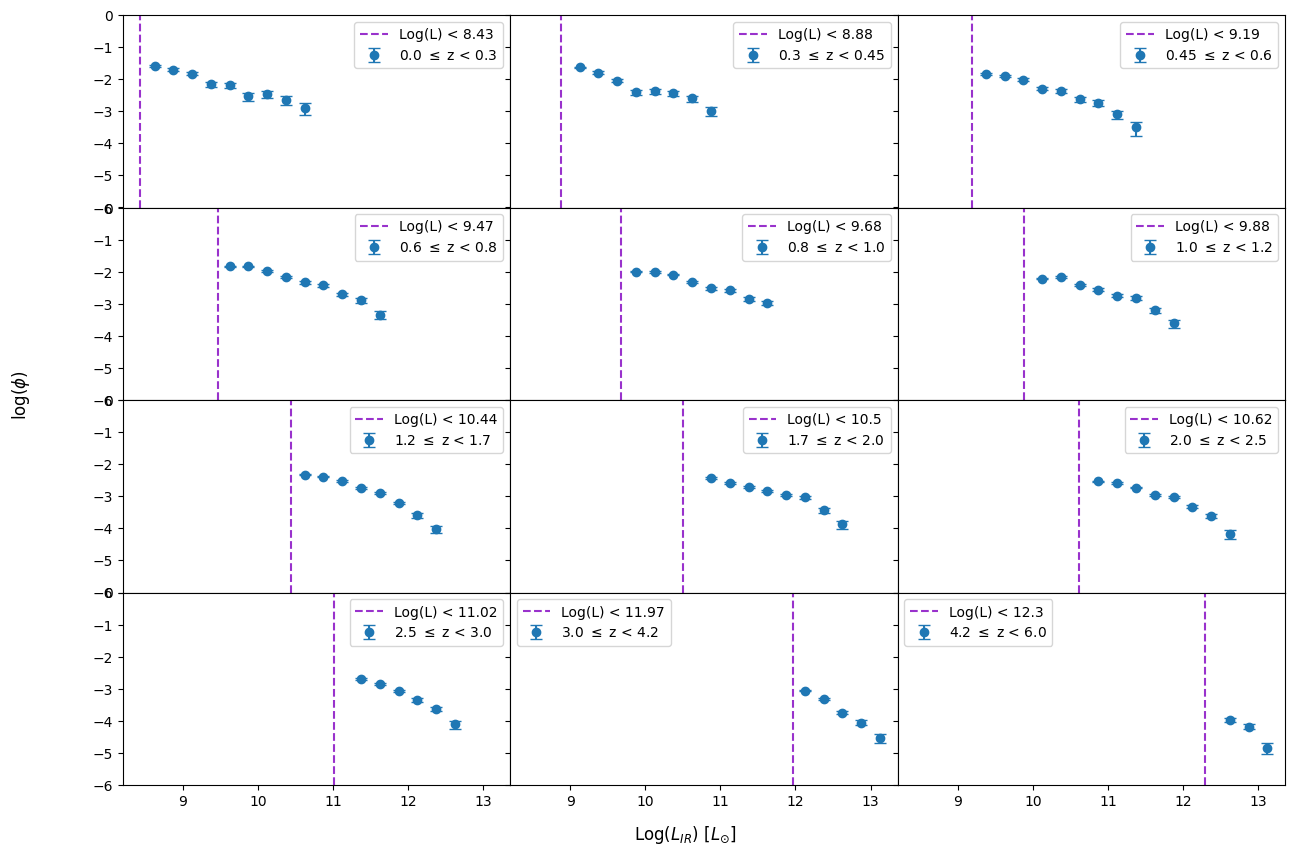

In [49]:
lum_centers, phi, phi_e = [], [], []

# Volume and luminosity are already binned by redshift
for (vol, lum), bin, in zip(all_data, bin_edges):
    
    try:
        delta_log_l = np.diff(bin)[0]
    except IndexError:
        lum_centers.append([])
        phi.append([])
        phi_e.append([])
        continue
    
    lum_centers_z, phi_z, phi_e_z = [], [], []

    # Bin by luminosity
    for lum_start, lum_end in zip(bin, bin[1:]):
        mask = (lum >= lum_start) & (lum < lum_end)
        vol_lum_bin = vol[mask]
        
        # Calculate the number density
        phi_val = (1 / delta_log_l) * np.sum(1 / vol_lum_bin)
        phi_err = (1 / delta_log_l) * np.sqrt(np.sum(1 / (vol_lum_bin ** 2)))
        
        # Save the luminosity bin and number density
        lum_centers_z.append((lum_start + lum_end) / 2)
        phi_z.append(phi_val)
        phi_e_z.append(phi_err)
    
    # Save the luminosity bins and number densities
    lum_centers.append(lum_centers_z)
    phi.append(phi_z)
    phi_e.append(np.array(phi_e_z))
    
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax, min_l in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten(), min_ls):
    try:
        yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    except TypeError:
        continue
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.axvline(np.log10(min_l), color='darkorchid', linestyle='--', label=f'Log(L) < {round(np.log10(min_l), 2)}')
    ax.set_ylim(-6, 0)
    ax.legend()

fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)

for (z_start, z_end), lum_centers_z, phi_z, phi_e_z in zip(redshift_bins, lum_centers, phi, phi_e):
    if len(lum_centers_z) == 0:
        continue
    print(f'{z_start} <= z < {z_end}')
    print(lum_centers_z)
    print(np.round(np.log10(phi_z),2))
    print(np.round((np.log10(phi_z) - np.log10(phi_z - phi_e_z)),2))
    print('\n')

### Schechter Fit

0.0 <= z < 0.3 Function fit:
Log L_star = 9.51 +/- 0.12
Log phi_star = -1.72 +/- 0.06
Alpha = 1.2


0.3 <= z < 0.45 Function fit:
Log L_star = 9.7 +/- 0.14
Log phi_star = -1.65 +/- 0.09
Alpha = 1.2


0.45 <= z < 0.6 Function fit:
Log L_star = 10.41 +/- 0.1
Log phi_star = -1.99 +/- 0.04
Alpha = 1.2


0.6 <= z < 0.8 Function fit:
Log L_star = 10.83 +/- 0.11
Log phi_star = -2.03 +/- 0.04
Alpha = 1.2


0.8 <= z < 1.0 Function fit:
Log L_star = 11.12 +/- 0.12
Log phi_star = -2.2 +/- 0.05
Alpha = 1.2


1.0 <= z < 1.2 Function fit:
Log L_star = 11.24 +/- 0.17
Log phi_star = -2.37 +/- 0.07
Alpha = 1.2


1.2 <= z < 1.7 Function fit:
Log L_star = 11.6 +/- 0.05
Log phi_star = -2.47 +/- 0.02
Alpha = 1.2


1.7 <= z < 2.0 Function fit:
Log L_star = 12.07 +/- 0.0
Log phi_star = -2.7 +/- 0.03
Alpha = 1.2


2.0 <= z < 2.5 Function fit:
Log L_star = 11.93 +/- 0.0
Log phi_star = -2.71 +/- 0.02
Alpha = 1.2


2.5 <= z < 3.0 Function fit:
Log L_star = 11.98 +/- 0.0
Log phi_star = -2.72 +/- 0.01
Alpha = 1.2


C:\Users\n10480129\AppData\Local\Temp\ipykernel_7064\3800613474.py:59: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
C:\Users\n10480129\AppData\Local\Temp\ipykernel_7064\3800613474.py:61: RuntimeWarning: divide by zero encountered in log10
  np.log10(schechter_luminosity(long_lum, *p_down)),
C:\Users\n10480129\AppData\Local\Temp\ipykernel_7064\3800613474.py:62: RuntimeWarning: divide by zero encountered in log10
  np.log10(schechter_luminosity(long_lum, *p_up)),


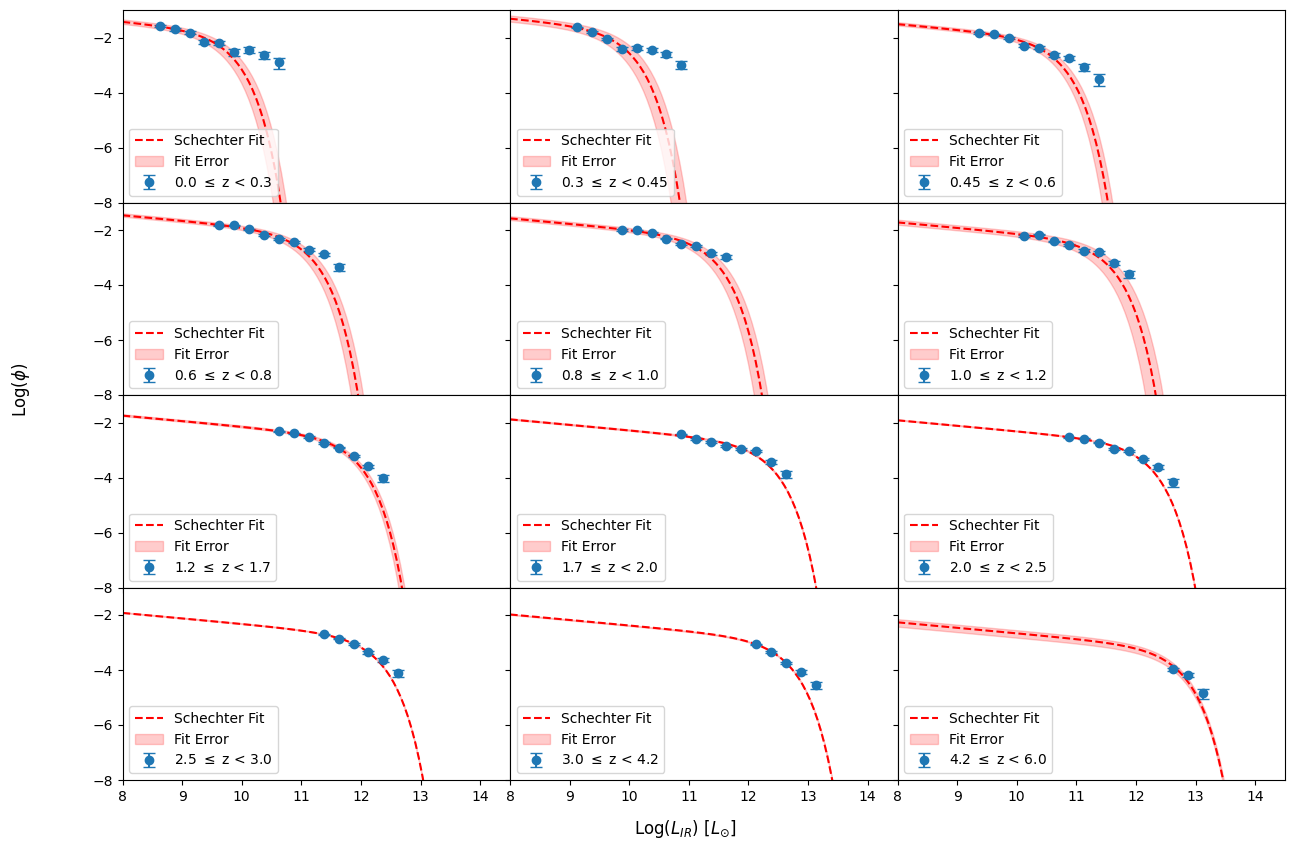

In [50]:
# def schechter_luminosity(L, L_star, phi_star):
#     return phi_star * 10 ** (-0.4*(1-1.2)*(L_star-L)) * np.exp(-10.**(-0.4*(L_star-L)))

def schechter_luminosity(L, L_star, phi_star):
    return phi_star * (L / L_star) ** (1-1.2) * np.exp(-L / L_star)

schecter_params = []
schecter_errors = []

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):

    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        schecter_params.append([])
        schecter_errors.append([])
        continue
    
    lum = np.power(10, lum)
    
    # Attempt to fit the data
    p0=[lum[0], 0.003]
    bounds = ([lum[0]/2, 1e-6], [lum[-1]*2, 1e-1])
    try:
        params, covars = curve_fit(schechter_luminosity, lum, p, p0=p0, bounds=bounds, maxfev=1000)
        perr = np.sqrt(np.diag(covars))
        p_up = params + perr
        p_down = np.abs(params - perr)
        schecter_params.append(params)
        schecter_errors.append(perr)
    except RuntimeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Maxfev reached.')
        schecter_params.append([])
        schecter_errors.append([])
        continue
    except TypeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Params: {len(params)} > data points: {len(lum)}.')
        schecter_params.append([])
        schecter_errors.append([])
        continue
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    # print(f'L_star = {params[0]:.2e} +/- {perr[0]:.2e}')
    # print(f'phi_star = {params[1]:.2e} +/- {perr[1]:.2e}')
    print(f'Log L_star = {np.round(np.log10(params[0]),2)} +/- {np.round(np.abs(np.log10(params[0]) - np.log10(params[0] - perr[0])),2)}')
    print(f'Log phi_star = {np.round(np.log10(params[1]),2)} +/- {np.round(np.abs(np.log10(params[1]) - np.log10(params[1] - perr[1])),2)}')
    print(f'Alpha = 1.2')
    
    
    
    if len(params) == 3:
        print(f'alpha = {params[2]:.2e}')
    print('\n')
    
    # Plot the data
    long_lum = np.logspace(8, 14, 100)
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(np.log10(lum), np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
    ax.fill_between(np.log10(long_lum),
        np.log10(schechter_luminosity(long_lum, *p_down)),
        np.log10(schechter_luminosity(long_lum, *p_up)),
        color='red', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower left')
    ax.set_ylim(-8, -1)
    ax.set_xlim(8, 14.5)

fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Saunders Fit

0.0 <= z < 0.3 Function fit:
Log L_star = 8.34 +/- 0.2
Log phi_star = -1.48 +/- 0.09
Alpha = 1.3
Sigma = 1.2


0.3 <= z < 0.45 Function fit:
Log L_star = 8.82 +/- 0.41
Log phi_star = -1.54 +/- 0.17
Alpha = 1.3
Sigma = 1.0


0.45 <= z < 0.6 Function fit:
Log L_star = 9.36 +/- 0.12
Log phi_star = -1.78 +/- 0.05
Alpha = 1.3
Sigma = 0.8


0.6 <= z < 0.8 Function fit:
Log L_star = 10.09 +/- 0.13
Log phi_star = -1.93 +/- 0.05
Alpha = 1.3
Sigma = 0.6


0.8 <= z < 1.0 Function fit:
Log L_star = 10.39 +/- 0.17
Log phi_star = -2.11 +/- 0.07
Alpha = 1.3
Sigma = 0.6


1.0 <= z < 1.2 Function fit:
Log L_star = 10.47 +/- 0.24
Log phi_star = -2.26 +/- 0.09
Alpha = 1.3
Sigma = 0.6


1.2 <= z < 1.7 Function fit:
Log L_star = 10.82 +/- 0.06
Log phi_star = -2.35 +/- 0.03
Alpha = 1.3
Sigma = 0.6


1.7 <= z < 2.0 Function fit:
Log L_star = 11.27 +/- 0.15
Log phi_star = -2.58 +/- 0.06
Alpha = 1.3
Sigma = 0.6


2.0 <= z < 2.5 Function fit:
Log L_star = 11.14 +/- 0.09
Log phi_star = -2.58 +/- 0.04
Alpha = 1.3

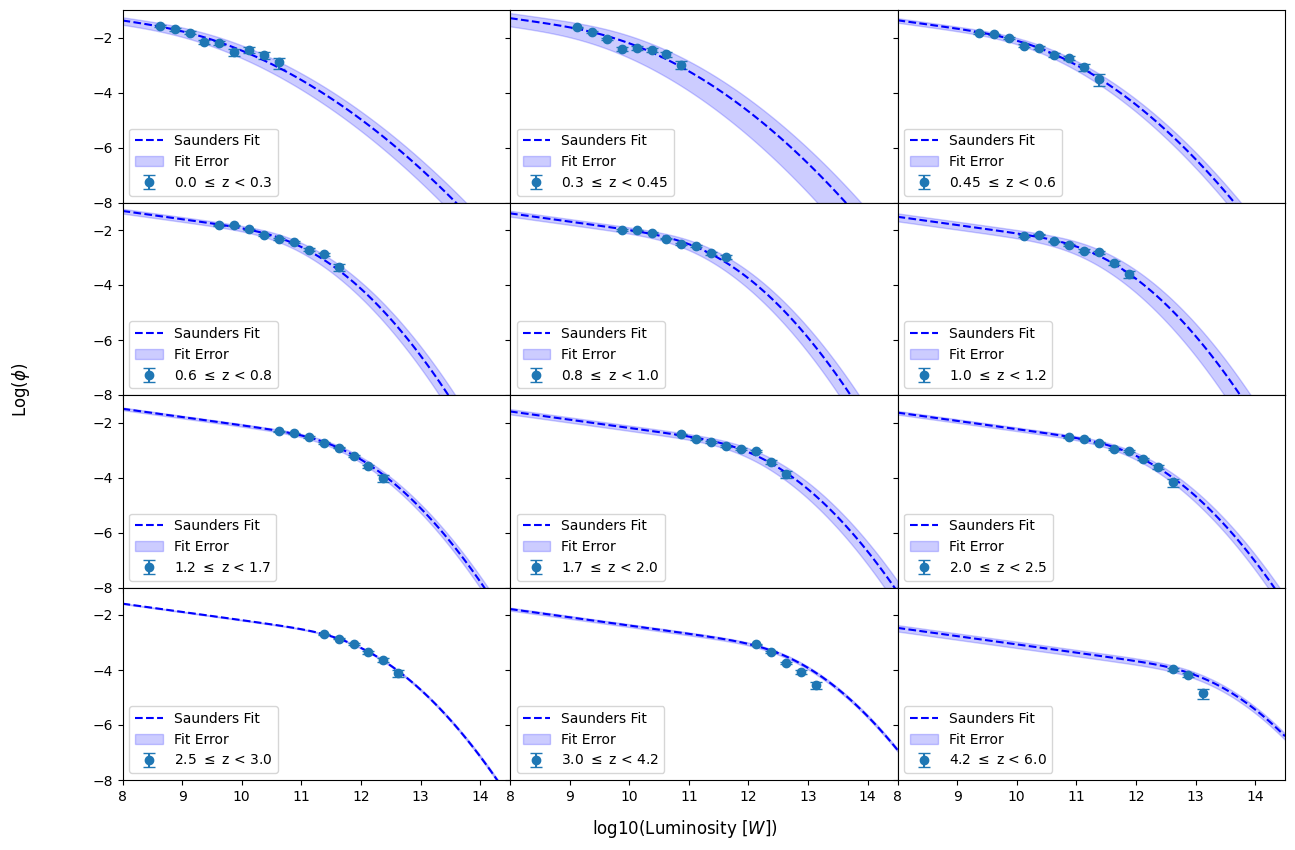

In [189]:
# def saunders_luminosity(L, L_star, phi_star):
#     return phi_star * 10 ** (-0.4*(1-1.2)*(L_star-L)) * np.exp(-1 / (2 * 0.2 ** 2) * (np.log10(1 + 10 ** (-0.4 * (L_star-L))))**2)

# def local_saunders_luminosity(L, L_star, phi_star):
#     return phi_star * 10 ** (-0.4*(1-2)*(L_star-L)) * np.exp(-1 / (2 * 0.4 ** 2) * (np.log10(1 + 10 ** (-0.4 * (L_star-L))))**2)

def saunders_luminosity(L, L_star, phi_star):
    return phi_star * (L / L_star) ** (1-1.3) * np.exp(-1 / (2 * 0.7 ** 2) * (np.log10(1 + (L / L_star)))**2)

def mid_saunders_luminosity(L, L_star, phi_star):
    return phi_star * (L / L_star) ** (1-1.3) * np.exp(-1 / (2 * 0.9 ** 2) * (np.log10(1 + (L / L_star)))**2)

def local_saunders_luminosity(L, L_star, phi_star):
    return phi_star * (L / L_star) ** (1-1.3) * np.exp(-1 / (2 * 1.0 ** 2) * (np.log10(1 + (L / L_star)))**2)

def first_saunders_luminosity(L, L_star, phi_star):
    return phi_star * (L / L_star) ** (1-1.3) * np.exp(-1 / (2 * 1.1 ** 2) * (np.log10(1 + (L / L_star)))**2)

saunder_params = []
saunder_error = []

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):
    
    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        saunder_params.append([])
        saunder_error.append([])
        continue
    
    lum = np.power(10, lum)
    
    if z_start == 0:
        f = first_saunders_luminosity
    elif z_start == 0.3:
        f = local_saunders_luminosity
    elif z_start == 0.45:
        f = mid_saunders_luminosity
    else:
        f = saunders_luminosity
    p0 = [lum[0], 1e-3]
    bounds = ([lum[0]/2, 1e-6], [lum[-1]*2, 1e-1])
    
    # Attempt to fit the data
    try:
        params, covars = curve_fit(f, lum, p, p0=p0, bounds=bounds, maxfev=10000)
        perr = np.sqrt(np.diag(covars))
        p_up = params + perr
        p_down = np.abs(params - perr)
        saunder_params.append(params)
        saunder_error.append(perr)
    except RuntimeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Maxfev reached.')
        saunder_params.append([])
        saunder_error.append([])
        continue
    except TypeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Params: {len(params)} > data points: {len(lum)}.')
        saunder_params.append([])
        saunder_error.append([])
        continue
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    # print(f'L_star = {params[0]:.2e} +/- {perr[0]:.2e}')
    # print(f'phi_star = {params[1]:.2e} +/- {perr[1]:.2e}')
    print(f'Log L_star = {np.round(np.log10(params[0]),2)} +/- {np.round(np.abs(np.log10(params[0]) - np.log10(params[0] - perr[0])),2)}')
    print(f'Log phi_star = {np.round(np.log10(params[1]),2)} +/- {np.round(np.abs(np.log10(params[1]) - np.log10(params[1] - perr[1])),2)}')
    print(f'Alpha = 1.3')
    
    if z_start == 0:
        print(f'Sigma = 1.2')
    elif z_start == 0.3:
        print(f'Sigma = 1.0')
    elif z_start == 0.45:
        print(f'Sigma = 0.8')
    else:
        print(f'Sigma = 0.6')
    
    if len(params) > 2:
        print(f'alpha = {params[2]:.2e} +/- {perr[2]:.2e}')
    if len(params) > 3:
        print(f'sigma = {params[3]:.2e} +/- {perr[3]:.2e}')
    print('\n')
    
    # Plot the data
    long_lum = np.logspace(8, 14.5, 100)
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(np.log10(lum), np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(np.log10(long_lum), np.log10(f(long_lum, *params)), color='blue', label='Saunders Fit', linestyle='--')   
    ax.fill_between(np.log10(long_lum), 
        np.log10(f(long_lum, *p_down)), 
        np.log10(f(long_lum, *p_up)), 
        color='blue', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower left')
    ax.set_ylim(-8, -1)
    ax.set_xlim(8, 14.5)

fig.supxlabel('log10(Luminosity [$W$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Parameter Evolution

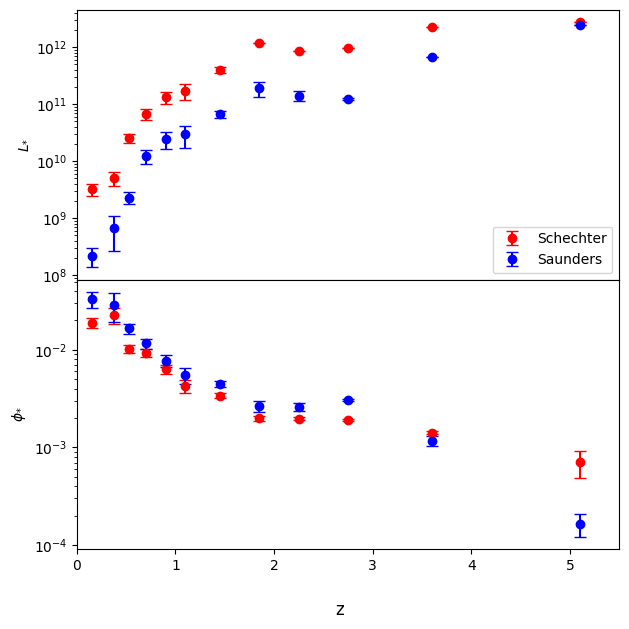

In [190]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7), sharex=True)

# Schechter Evolution
for i, ((z_start, z_end), p, e) in enumerate(zip(redshift_bins, schecter_params, schecter_errors)):
    z_center = (z_start + z_end) / 2
    try:
        ax[0].errorbar(z_center, p[0], yerr=e[0], fmt='o', capsize=4, color='red', label='Schechter' if i == 0 else "")
        ax[1].errorbar(z_center, p[1], yerr=e[1], fmt='o', capsize=4, color='red')
    except IndexError:
        continue

# Saunders Evolution
for i, ((z_start, z_end), p, e) in enumerate(zip(redshift_bins, saunder_params, saunder_error)):
    z_center = (z_start + z_end) / 2
    try:
        ax[0].errorbar(z_center, p[0], yerr=e[0], fmt='o', capsize=4, color='blue', label='Saunders' if i == 0 else "")
        ax[1].errorbar(z_center, p[1], yerr=e[1], fmt='o', capsize=4, color='blue')
    except IndexError:
        continue

ax[0].set_ylabel('$L_{*}$')
ax[1].set_ylabel('$\phi_{*}$')
ax[0].legend(loc='lower right')
ax[1].set_xlim(0, 5.5)
ax[0].set_yscale('log')
ax[1].set_yscale('log')

fig.supxlabel('z')
plt.subplots_adjust(hspace=0)
plt.show()

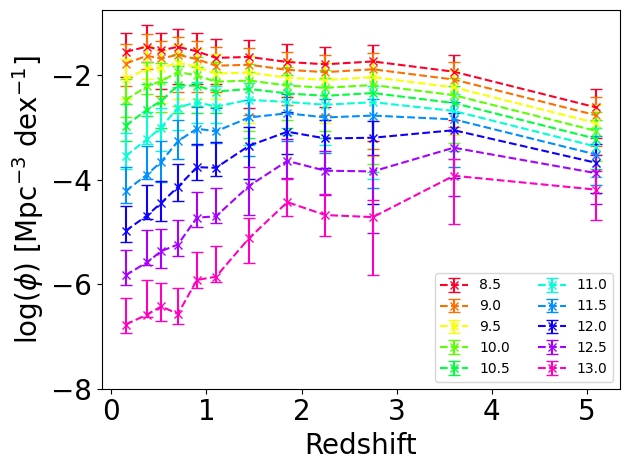

In [191]:
redshift_centers = np.mean(redshift_bins, axis=1)
luminosity_centers = np.arange(8.5, 13.5, 0.5) # luminosity bin edges
colors = plt.cm.gist_rainbow(np.linspace(0,1,len(luminosity_centers)))

# Iterate over the luminosity bins
est_phi = []
est_phi_e = []
new_z = []
for l_center in luminosity_centers:
    est_phi_z = []
    est_phi_e_z = []
    new_z_z = []

    # Iterate over the redshift bins:
    for lum_z, z_val, params, perr in zip(lum_centers, redshift_centers, saunder_params, saunder_error):
        
        if z_val == 0.15:
            f = first_saunders_luminosity
        elif z_val == 0.375:
            f = local_saunders_luminosity
        elif z_val == 0.525:
            f = mid_saunders_luminosity
        else:
            f = saunders_luminosity
        
        # Calculate the number density of the missing luminosity bin
        est_phi_z.append(f(10**l_center, *params))
        est_phi_e_z.append([f(10**l_center, *(params - perr)), f(10**l_center, *(params + perr))])
        new_z_z.append(z_val)
            
    est_phi.append(est_phi_z)
    est_phi_e.append(est_phi_e_z)
    new_z.append(new_z_z)
    
# Plot the estimated number densities
for nz, nphi, lcent, c, nphie in zip(new_z, est_phi, luminosity_centers, colors, est_phi_e):
    # plt.plot(nz, np.log10(nphi), '--x', label=f'{lcent}', color=c)
    nphie = np.array(nphie).T
    nphi = np.array(nphi)
    yerr = [np.log10(nphi) - np.log10(nphi - nphie[0]), np.log10(nphi + nphie[1]) - np.log10(nphi)]
    plt.errorbar(nz, np.log10(nphi), yerr=yerr, capsize=4, color=c, label=f'{lcent}', linestyle='--', marker='x')
    
# plt.yscale('log')
plt.legend(ncols=2)
plt.xlabel('Redshift', fontsize=20)
plt.ylabel('log($\phi$) [Mpc$^{-3}$ dex$^{-1}$]', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks([-8, -6, -4, -2], fontsize=20)
# plt.yticks([10**-8, 10**-6, 10**-4, 10**-2], fontsize=20)
plt.tight_layout()
plt.savefig('phi_density_evo.png')
plt.show()

### Export

In [192]:
file_name = 'fits/alt_galaxy_dat_11_10_9_7'
np.savez(file_name, 
    x=np.array(lum_centers, dtype=object), 
    y=np.array(phi, dtype=object), 
    e=np.array(phi_e, dtype=object),
    z=np.array(redshift_bins, dtype=object),
    m=np.array(min_ls, dtype=object),
    schech_p=np.array(schecter_params, dtype=object),
    saunder_p=np.array(saunder_params, dtype=object),
    schech_e=np.array(schecter_errors, dtype=object),
    saunder_e=np.array(saunder_error, dtype=object))